In [58]:
import numpy as np
import tensorflow as tf
from stochastic.processes.continuous import FractionalBrownianMotion
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

In [195]:
def gen_fbm_data(nsamples,ntimes,hurst_const=None):
    """ 
    Function to produce fractional brownian motion data for neural network 
    training and testing
    Inputs: nsamples; number of samples, ntimes; number of times
    Outputs: traindata; training data for NN, trainlabels; labels associated 
            with traindata
    """
    data = np.empty((nsamples,ntimes+1,3))
    labels = np.empty((nsamples,1))
    for i in range(0,nsamples):
        if hurst_const == None:
            hurst_exp = np.random.uniform(0.,1.)
        else:
            hurst_exp = hurst_const
        fbm = FractionalBrownianMotion(hurst=hurst_exp,t=1,rng=None)
        x = fbm.sample(ntimes)
        y = fbm.sample(ntimes)
        z = fbm.sample(ntimes)
        #apply differencing and normalization on the data
        #dx = (x[1:]-x[0:-1])/(np.amax(x)-np.amin(x))
        #dy = (y[1:]-x[0:-1])/(np.amax(y)-np.amin(y))
        #dz = (z[1:]-x[0:-1])/(np.amax(z)-np.amin(z))
        data[i,:] = np.array([x,y,z]).transpose()
        labels[i,:] = hurst_exp
        
    return data,labels

In [196]:
data,labels = gen_fbm_data(100,50,hurst_const=0.9)

In [197]:
def plot_random_walks(steps, init_pos=[0,0,0]):
    
    fig = plt.figure()
    ax = Axes3D(fig)
    for i,_ in enumerate(steps):
        ax.plot(steps[i,:,0],steps[i,:,1],steps[i,:,2])
        
    return

<IPython.core.display.Javascript object>


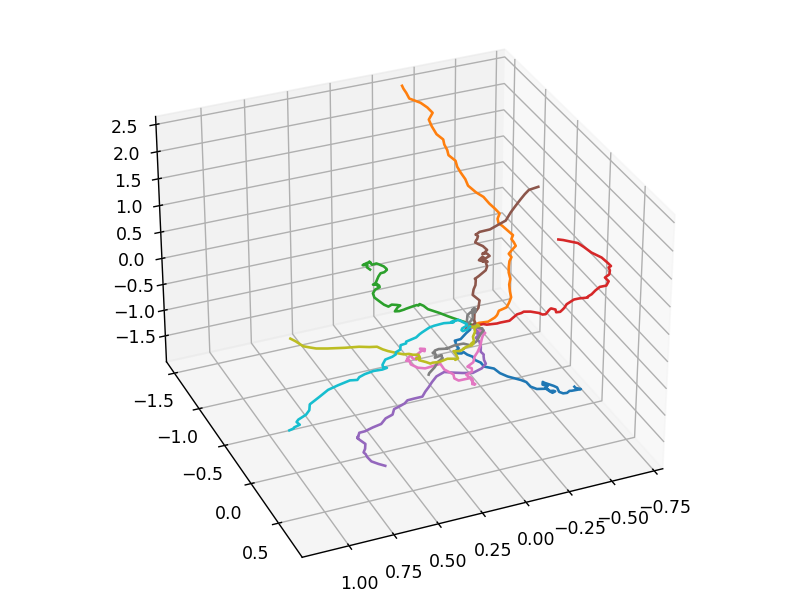

In [198]:
plot_random_walks(data[:10])